# Lime For SVM Model

In [16]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import pickle

In [17]:
# Define paths
photos_folder = "C:/Users/indra/OneDrive - Loyalist College/Sem 3/CV/yelp_photos/photos"
photos_json_path = "C:/Users/indra/OneDrive - Loyalist College/Sem 3/CV/yelp_photos/photos.json"

# Load JSON data
photos_df = pd.read_json(photos_json_path, lines=True)

print(photos_df.head())

                 photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food  


In [18]:
# Load the SVM model
with open("svm_model.pkl", "rb") as f:
    svm_model = pickle.load(f)

  0%|          | 0/1000 [00:00<?, ?it/s]

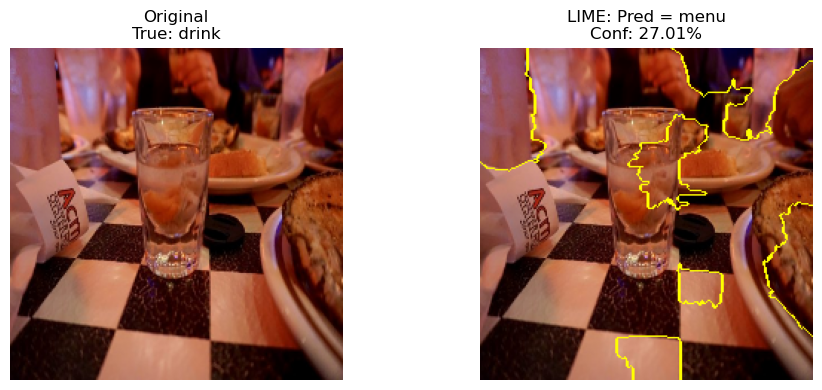

  0%|          | 0/1000 [00:00<?, ?it/s]

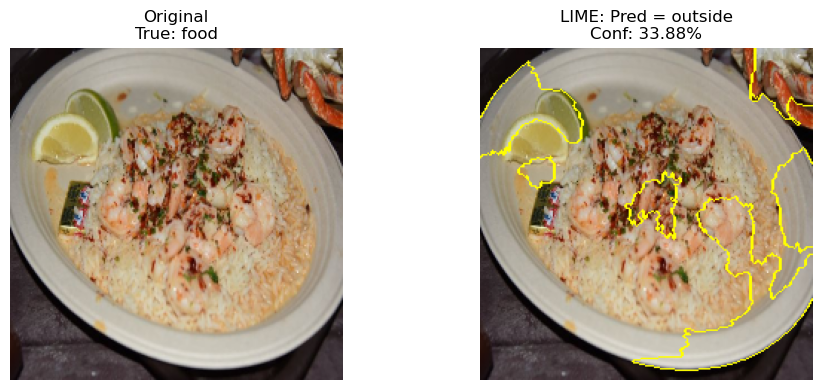

  0%|          | 0/1000 [00:00<?, ?it/s]

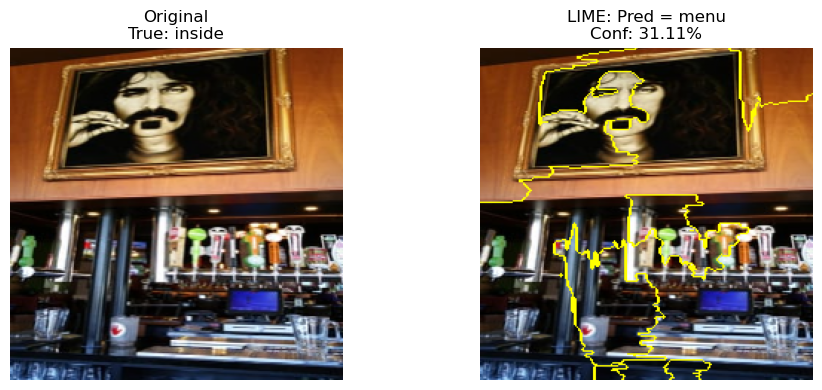

  0%|          | 0/1000 [00:00<?, ?it/s]

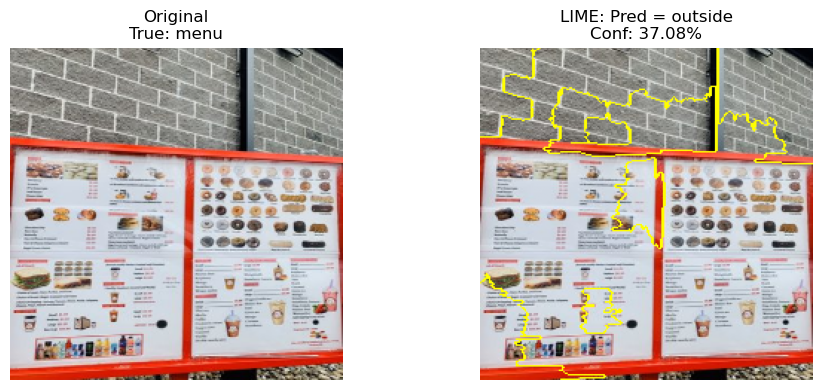

  0%|          | 0/1000 [00:00<?, ?it/s]

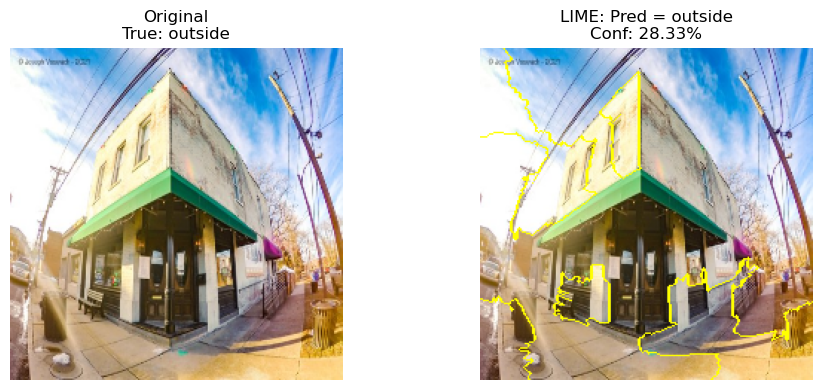

In [19]:
# Define class names 
class_names = ['inside', 'outside', 'drink', 'food', 'menu']

# Create mapping from string labels to integer indices
label_to_int = {name: idx for idx, name in enumerate(class_names)}

# Preprocess image for LIME (RGB, resized, scaled)
def preprocess_for_lime(photo_id):
    path = os.path.join(photos_folder, f"{photo_id}.jpg")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img  

# Prediction wrapper (flattens RGB images for SVM)
def predict_fn(images):
    flattened = np.array([img.flatten() for img in images])  
    return svm_model.predict_proba(flattened)

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Select one photo per class label
images_per_class = {}
for label in sorted(photos_df['label'].unique()):
    subset = photos_df[photos_df['label'] == label]
    for _, row in subset.iterrows():
        path = os.path.join(photos_folder, f"{row['photo_id']}.jpg")
        if os.path.exists(path):
            images_per_class[label_to_int[label]] = row['photo_id']
            break

# Run LIME for each selected image
for label_idx, photo_id in images_per_class.items():
    image_rgb = preprocess_for_lime(photo_id)
    image_uint8 = (image_rgb * 255).astype(np.uint8)

    # Run LIME explanation
    explanation = explainer.explain_instance(
        image=image_uint8,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Get prediction
    probs = predict_fn([image_rgb])[0]
    pred_label = np.argmax(probs)
    pred_prob = probs[pred_label]
    pred_name = class_names[pred_label]
    true_name = class_names[label_idx]

    # Plot original and LIME explanation
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].imshow(image_uint8)
    axes[0].set_title(f"Original\nTrue: {true_name}")
    axes[0].axis('off')

    axes[1].imshow(mark_boundaries(temp / 255.0, mask))
    axes[1].set_title(f"LIME: Pred = {pred_name}\nConf: {pred_prob:.2%}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [20]:
# Print top contributing regions for all classes with interpretation
for label, photo_id in sorted(images_per_class.items()): 
    image = preprocess_for_lime(photo_id)

    explanation = explainer.explain_instance(
        image.astype('double'),
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    top_regions = explanation.local_exp[explanation.top_labels[0]]

    print(f"🟨 Class {label} — Photo ID: {photo_id}")
    print("Top contributing regions (feature index, weight):")
    print(top_regions)
    
    print("=" * 150)


  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class 0 — Photo ID: zsvj7vloL4L5jhYyPIuVwg
Top contributing regions (feature index, weight):
[(11, -0.010486440016584893), (20, -0.009540856869349324), (8, 0.008555884381057368), (26, -0.008456785042884392), (21, -0.007457062684875532), (19, -0.006589878017831488), (2, 0.005522422010359849), (9, -0.00545633535044811), (24, -0.005386726391850245), (14, -0.005120274612777194), (3, 0.004911823316507554), (1, -0.004809314711148944), (15, -0.004379426910154283), (0, 0.004359382076028751), (23, -0.0038710093970647065), (29, -0.0035874182336386802), (36, -0.003203077736589202), (10, -0.0015253237320030251), (7, -0.0008320391985853267), (12, 0.000653877781999091), (4, 0.0006212776217974411), (18, -0.0005681130080139576), (6, 0.0005151600030264512), (22, -0.00047225874048130337), (17, -0.0004597110429744793), (34, -0.00044342197015786734), (16, -0.0004168680619518856), (38, 0.0004111712262713623), (30, 0.0003412356973943316), (13, 0.0003169871321259196), (35, -0.0003132030833386256), (27, 0.0

  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class 1 — Photo ID: HCUdRJHHm_e0OCTlZetGLg
Top contributing regions (feature index, weight):
[(26, 0.013472922474369362), (4, 0.011925853163935707), (7, 0.010667263239219857), (21, 0.00935943243925231), (36, 0.00867786557524998), (25, 0.006900051185240256), (30, 0.0066044032448620135), (14, 0.005935089187713591), (37, 0.0058292474839579346), (24, 0.005777222048259264), (34, 0.00545364143647821), (35, 0.005223838427114831), (33, 0.004859770497863871), (13, -0.004627594557096196), (18, 0.004509823813969432), (28, 0.004430826390154211), (22, 0.004130828433783441), (2, 0.004013003033471987), (32, 0.0035475323544459205), (23, 0.0035236001807605936), (40, 0.0032173540995785463), (9, 0.0030962719702225705), (29, 0.003052962350755681), (1, 0.003052241877858104), (27, 0.002764644687791424), (17, 0.0021591822359401467), (8, 0.002067357339298968), (31, 0.002060605121094293), (12, 0.001720700802828766), (16, -0.0014939493904534964), (38, 0.0013193687506320038), (10, 0.0012820987539018068), (5, -

  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class 2 — Photo ID: vkr8T0scuJmGVvN2HJelEA
Top contributing regions (feature index, weight):
[(37, -0.011217441722873183), (38, -0.010602897460484173), (30, -0.010241858497532919), (16, -0.00926477083249818), (17, -0.00878297416224967), (21, -0.008065109742086508), (29, -0.006993949599534613), (12, -0.006183205033887384), (18, 0.006145396599385282), (34, -0.00597973675696093), (28, -0.005875519625277779), (26, -0.004803725368134389), (31, -0.004709784275811677), (35, -0.00441249652906806), (14, 0.004235471079213578), (24, -0.0038904912339013313), (1, -0.0034931062419235187), (11, -0.0032139045294109886), (2, 0.0026102319293452155), (5, 0.0024375447153324563), (10, 0.0023320214270470896), (27, -0.0023270173403765982), (4, 0.0022730060948010864), (15, -0.002152275658290109), (13, 0.0017416044985930396), (40, -0.0017398765427400283), (33, -0.0012851413015746338), (25, 0.0011844263523396196), (36, -0.001174028748195463), (8, 0.001136069590286304), (19, 0.0011232499340709074), (32, -0.000

  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class 3 — Photo ID: pve7D6NUrafHW3EAORubyw
Top contributing regions (feature index, weight):
[(27, 0.027391720205098762), (2, 0.018612105956170733), (32, 0.018593707430877616), (26, 0.01623034090372352), (29, 0.014145477050287483), (31, 0.010200700547877247), (25, 0.009865215986806373), (21, 0.007964363663693522), (4, 0.007026443704447883), (7, 0.006241104426552832), (8, 0.006041084536911881), (23, 0.005773672380579403), (33, 0.005175776739241313), (20, 0.004901295415946407), (6, 0.004758550508265337), (24, 0.004546051018838266), (35, 0.004065443596225347), (34, 0.0034645150355358287), (3, 0.0030531853434852853), (28, 0.0023612597523206607), (11, 0.0020769311887739775), (30, 0.0020290216851959605), (12, 0.001999212690673023), (17, -0.0019783019802267904), (22, 0.0015536584615973884), (13, -0.001365202810756354), (16, -0.0012321696757765274), (19, 0.0012266413913446523), (5, 0.0012041535572999225), (14, -0.001064612357112333), (36, 0.0009605986023690284), (15, -0.0006895923164859903),

  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class 4 — Photo ID: 6LJa8QZOGBjt9maE5miLhw
Top contributing regions (feature index, weight):
[(24, 0.02447867601501371), (31, 0.021145799404731283), (28, 0.020536473768628473), (38, 0.015455636530488436), (35, 0.010032086201919276), (27, 0.00873441782942171), (37, 0.008534260257686097), (1, 0.008533254713331221), (26, 0.007633998824757471), (3, 0.006838236773934418), (29, 0.006836945314367073), (8, 0.006687159457488649), (25, 0.006401920401787604), (33, 0.006225353116948742), (30, 0.006101450244223629), (34, 0.005727532522414048), (5, 0.004171691792744822), (23, 0.0037584067382887346), (32, 0.0036625161867591205), (10, 0.00361162637691942), (36, 0.0035655789866572726), (12, 0.0035381332993580984), (15, -0.003519771285392429), (4, 0.003260075405321403), (7, 0.0031650851674175627), (40, 0.0031077824699452966), (22, 0.003002064866471158), (18, 0.0024722156373963274), (0, 0.002255170499067916), (13, -0.0022049445142241276), (17, -0.0021805034324629065), (2, 0.0021514629338505297), (6, 0.

#  LIME Interpretation 

---

###  **Image 1 — Original Class: `drink`**
- **LIME Prediction**: `menu` with **27.01% confidence**
- **Insight**: Very low confidence and incorrect prediction.
- **Interpretation**: Model is unsure. The visual overlap between glasses and menu layouts may have caused confusion, but no strong region influenced the prediction.

---

### **Image 2 — Original Class: `food`**
- **LIME Prediction**: `outside` with **33.88% confidence**
- **Misclassified** at low confidence.
- **Interpretation**: Model likely misinterpreted lime or crab shells as background elements from outdoor settings. Yellow contours are scattered and inconsistent.

---

### **Image 3 — Original Class: `inside`**
- **LIME Prediction**: `menu` with **31.11% confidence**
- Incorrect prediction with low confidence.
- **Interpretation**: The model was misled by framed artwork or the bar arrangement, possibly resembling structured menu layouts.

---

### **Image 4 — Original Class: `menu`**
- **LIME Prediction**: `outside` with **37.08% confidence**
- ❌ Misclassified.
- **Interpretation**: Despite showing a clear menu board, the model focused more on the **brick wall** and surroundings, associating it with outdoor scenes.

---

### **Image 5 — Original Class: `outside`**
- **LIME Prediction**: `outside` with **28.33% confidence**
- Correct, but low confidence.
- **Interpretation**: The model recognized some outdoor features (like sky, poles, buildings), though confidence was weak. Highlighted regions align with outdoor cues.
